In [1]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
@everywhere include(src_path*"jackknife_estimates.jl")
@everywhere include(src_path*"dist_lists.jl")
@everywhere include(src_path*"parallel_tempering.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
fixRC()
# We run a simulation with the parameters
g = 1.0    # Gauge coupling
ν = 0.3    # Anisotropy

# Other parameters
L = 24     # System length
L₃ = 24
N = L^2*L₃
# Make geometric progression of temperatures between T₁ and Tₘ
T₁ = 1.7
Tₘ = 2.0
N_temp = 2^4
R = (Tₘ/T₁)^(1/(N_temp-1))
T_list = [T₁*R^(k-1) for k = 1:N_temp]
T_list = reverse(T_list)
println("Temps.: $(T_list)")
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = 0.0/L
println("f set to $(f)")
sim = Controls(π-π/12, 1.0, 0.7)

# Setup measurement storage
N_T = length(T_list)

ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);

# Make ab inito un-correlated phases state
init_syst_list = [SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T) for T in T_list]
init_ψ_list = [State(1, syst; u⁺=1.0, u⁻=0.0) for syst in init_syst_list]
init_sim_list = [copy(sim) for syst in init_syst_list];
#ψ_ref = State(2, init_syst_list[1]; u⁺=1.0, u⁻=0.0)

# Making parallel tempering variables
pt = PTRun(init_ψ_list, init_sim_list, 1);


Temps.: [2.0, 1.97845, 1.95713, 1.93604, 1.91517, 1.89454, 1.87412, 1.85393, 1.83395, 1.81418, 1.79463, 1.7753, 1.75616, 1.73724, 1.71852, 1.7]
f set to 0.0


# Single Histogram Reweighting

In [3]:
mutable struct FSReweight
    β::Float64
    E_list::Array{Float64, 1}
end

# Calculates a list of weights based on the energies in rw, following the formula
# wᵢ = e^{-(β′-β)(Eᵢ-E₁)}/(1 + sum_2^M e^{-(β′-β)(Eᵢ-E₁)})
function weights(rw::FSReweight, β′::Float64)
    l = length(rw.E_list)
    w_list = Array{Float64}(undef, l)
    E₁ = rw.E_list[1]
    s = 0.0
    # Calculate the sum in the denominator.
    for i = 2:l
        s += exp(-(β′-rw.β)*(rw.E_list[i]-E₁))
    end
    # Calculate the different weights.
    for i = 1:l
        w_list[i] = exp(-(β′-rw.β)*(rw.E_list[i]-E₁))/(1+s)
    end
    return w_list
end

weights (generic function with 1 method)

In [4]:
function reweight(rw::FSReweight, β′::Float64, O_list::Array{Float64, 1})
    w_list = weights(rw, β′)
    O = 0.0
    for i = 1:length(w_list)
        O += w_list[i]*O_list[i]
    end
    O
end

reweight (generic function with 1 method)

# Testing FSReweight
### First getting some raw MC measurements for different temperatures.

In [5]:
M = 2^7
# Energy lists
E_matrix = Array{Float64}(undef, M, length(T_list));
function E(pt::PTRun)
    return pt.E_list[pt.rep_map]
end
# Do M parallel tempering steps
t_PT = @elapsed for i = 1:M
    PTStep!(pt)
    E_matrix[i, :] = E(pt)
end
E_matrix = E_matrix./N;
t_PT = t_PT/M
t_MCS = t_PT/pt.N_temp
println("We did $(M) PT steps using average $(round(t_PT*1000; digits=1)) ms pr PT step. Each PT step
had $(pt.N_temp) temperatures, thus $(pt.N_temp*M) MCS was done. This yields $(round(t_MCS*1000; digits=1)) ms
on average for each MCS.")

We did 128 PT steps using average 333.0 ms pr PT step. Each PT step
had 16 temperatures, thus 2048 MCS was done. This yields 20.8 ms
on average for each MCS.


In [1]:
plot([E_matrix[:, i] for i = 1:size(E_matrix,2)])

UndefVarError: UndefVarError: E_matrix not defined

In [7]:
# Adjusting simulation constants and restarting parallel tempering
ψ_list = [R.ψ for R in localize(pt.dr_list)]
sim_list = [R.sim for R in localize(pt.dr_list)]
@time adjustSimConstants!(ψ_list, sim_list);
sim_list = [sim_list[1] for sim in sim_list]
pt = PTRun(ψ_list, sim_list, 1);

129.625752 seconds (175.19 M allocations: 5.048 GiB, 10.64% gc time)


In [8]:
M = 2^12
# Setup storage for ρˣˣₖ₂
ρˣ₂_by_T = Array{Array{Float64, 1}}(undef, length(T_list))
E_by_T = Array{Array{Float64, 1}}(undef, length(T_list))
for i = 1:length(T_list)
    ρˣ₂_by_T[i] = Array{Float64}(undef, M)
    E_by_T[i] = Array{Float64}(undef, M)
end

# Between each measurement we do Δt PTMCS
Δt = 40
println("We will now do $(Δt*M*pt.N_temp) MCS in $(Δt*M) PT steps which has an 
ETC of $(round(Δt*M*t_PT/3600; digits=1)) h")
println("Started measurements at: $(Dates.format(now(), "HH:MM"))")

We will now do 2621440 MCS in 163840 PT steps which has an 
ETC of 15.2 h
Started measurements at: 17:31


In [14]:
# We preform M measurements
@time for m = 1:M
    for j = 1:Δt
        PTStep!(pt)
    end
    all_res = dmap(R -> gaugeStiffness([R.ψ]), pt.dr_list)
    En_res = E(pt)
    # Sort results in terms of temperature and extract ρˣˣₖ₂.
    for (i, res) = enumerate(all_res[pt.rep_map])
        ρˣ₂_by_T[i][m] = res[1][1]
        E_by_T[i][m] = En_res[i]
    end
end

52924.170216 seconds (335.28 M allocations: 14.152 GiB, 0.02% gc time)


In [25]:
for i = 1:N_T
    jv = jackVars(mean, ρˣ₂_by_T[i], 2^5; skip_check=true)
    ρˣ₂_avg_by_T[i], var = jackEstimate(jv)
    ρˣ₂_err_by_T[i] = √(var)
end

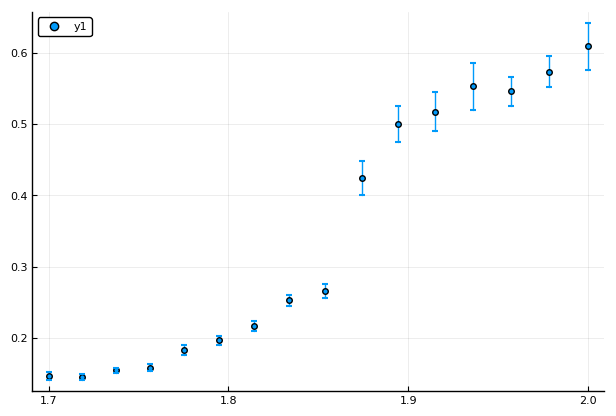

In [27]:
plt = scatter(reverse(T_list), L.*ρˣ₂_avg_by_T, yerror=L.*ρˣ₂_err_by_T)
savefig(plt, "Fantastic plot")

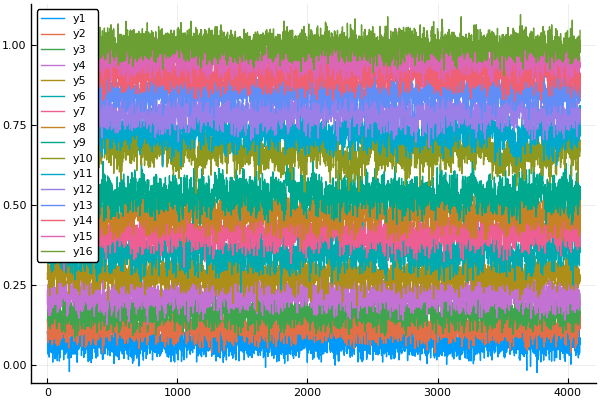

In [17]:
plot(E_by_T./N)

# Extending temperature range with SH Reweighting
### First we take the measurement at T[i] and use single histogram FS to find the measurements at all temperatures in ( T[i], T[i+1] )

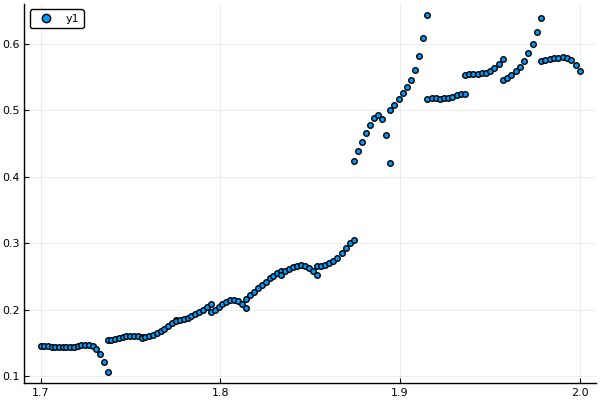

In [18]:
old_T_list = [1/β for β in pt.β_list]
l = length(old_T_list)
amp = 10
rw_ρ_list = Array{Float64}(undef, (l-1)*amp)
rw_T_list = Array{Float64}(undef, (l-1)*amp)
for I = 1:l-1
    rw_T_list[(I-1)*amp+1] = old_T_list[I]
    rw_ρ_list[(I-1)*amp+1] = ρˣ₂_avg_by_T[I]
    rw = FSReweight(1/old_T_list[I], E_by_T[I])
    for i = 2:amp
        rw_T_list[(I-1)*amp+i] = old_T_list[I] + (old_T_list[I+1]-old_T_list[I])/(amp-1)*(i-1)
        rw_ρ_list[(I-1)*amp+i] = reweight(rw, 1/rw_T_list[(I-1)*amp+i], ρˣ₂_by_T[I])
    end
end
scatter(rw_T_list, L.*rw_ρ_list)

### Use the temperature at T[i] and use single histogram FS to find measurements for temperatures ( T[i]-half_width, T[i] + half_width ).

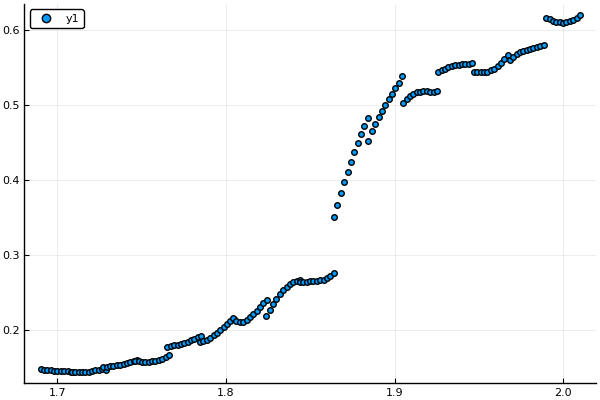

In [19]:
# Maybe it becomes better if we reweight around the temperature in-stead of in front of it.
half_width = 0.01
rw_num = 5                          # Number of reweight temperatures on each side of original temperature.
old_T_list = [1/β for β in pt.β_list]
l = length(old_T_list)
rw_ρ_list = Array{Float64}(undef, l*(2*rw_num+1))
rw_T_list = Array{Float64}(undef, l*(2*rw_num+1))

for I = 1:l
    rw = FSReweight(1/old_T_list[I], E_by_T[I])
    # Add temperatures and reweights on left side of temp.
    for i = 1:rw_num
        rw_T_list[(I-1)*(2*rw_num+1)+i] = old_T_list[I] - half_width*(rw_num-i+1)/rw_num
        rw_ρ_list[(I-1)*(2*rw_num+1)+i] = reweight(rw, 1/rw_T_list[(I-1)*(2*rw_num+1)+i], ρˣ₂_by_T[I])
    end
    # Add temperature and oridinal in middle
    rw_T_list[(I-1)*(2*rw_num+1)+rw_num+1] = old_T_list[I]
    rw_ρ_list[(I-1)*(2*rw_num+1)+rw_num+1] = reweight(rw, 1/old_T_list[I], ρˣ₂_by_T[I])
    # Add temperatures and reweights on right side of old temp.
    for i = 1:rw_num
        rw_T_list[(I-1)*(2*rw_num+1)+rw_num+1+i] = old_T_list[I] + half_width*i/rw_num
        rw_ρ_list[(I-1)*(2*rw_num+1)+rw_num+1+i] = reweight(rw, 1/rw_T_list[(I-1)*(2*rw_num+1)+rw_num+1+i], ρˣ₂_by_T[I])
    end
end
scatter(rw_T_list, L.*rw_ρ_list)

### Use a single measurement and single histogram FS to find measurements over an extended temperature range

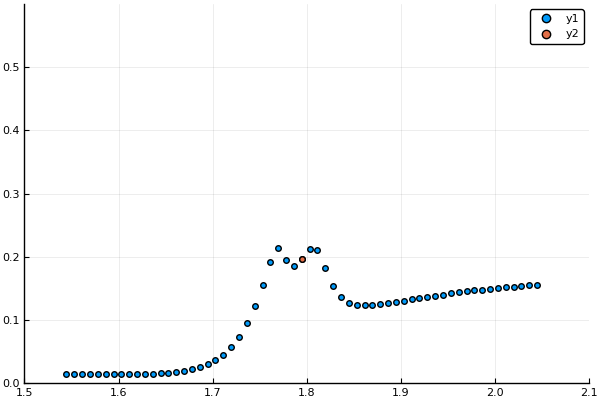

In [20]:
I = 6
half_width = 0.25
rw_num = 30
old_T_list = [1/β for β in pt.β_list]
rw = FSReweight(pt.β_list[I], E_by_T[I]);
rw_T_list = [T for T = old_T_list[I]-half_width:half_width/rw_num:old_T_list[I]+half_width]
rw_ρ_list = [reweight(rw, 1/T, ρˣ₂_by_T[I]) for T in rw_T_list]
scatter(rw_T_list, L.*rw_ρ_list; xlim=(1.5, 2.1), ylim=(0, 0.6))
scatter!([1/pt.β_list[I]], [L*mean(ρˣ₂_by_T[I])])

In [22]:
sum(weights(rw, 1/rw_T_list[4]))

1.0000000000000002

# Saving results to file

In [8]:
using DelimitedFiles

In [191]:
println(typeof(ρˣ₂_by_T))
println(typeof(E_by_T))
println(typeof(pt.β_list))

Array{Array{Float64,1},1}
Array{Array{Float64,1},1}
Array{Float64,1}


In [212]:
# Make arrays into matrices
n = length(ρˣ₂_by_T[1])
results = [ρˣ₂_by_T[i][j] for j = 1:n, i = 1:length(ρˣ₂_by_T)]
@test results[:, 1] == ρˣ₂_by_T[1]
n = length(E_by_T[1])
energies = [E_by_T[i][j] for j = 1:n, i = 1:length(E_by_T)]
@test energies[:, 1] == E_by_T[1]

Test Passed

In [218]:
writedlm("results", results, ":")
writedlm("energies", energies, ":")
writedlm("b_list", pt.β_list, ":")

# Loading results from text files

In [5]:
new_energies = readdlm("energies", ':', Float64)
new_results = readdlm("results", ':', Float64)
new_b_list = readdlm("b_list", ':', Float64);

In [226]:
@test results == new_results

Test Passed

In [22]:
size(new_energies, 2)

16

In [6]:
N₀ = size(new_results, 2)
ρˣ₂_by_T = Array{Array{Float64, 1}, 1}(undef, N₀)
E_by_T = Array{Array{Float64, 1}, 1}(undef, N₀)
for k = 1:N₀
    ρˣ₂_by_T[k] = new_results[:, k]
    E_by_T[k] = new_energies[:, k]
end
β_list = new_b_list

16×1 Array{Float64,2}:
 0.5882352941176471
 0.5818964044262726
 0.575625823323181 
 0.5694228147073422
 0.563286650410033 
 0.5572166101093589
 0.5512119812456945
 0.5452720589380379
 0.5393961459012631
 0.5335835523642679
 0.5278335959890009
 0.522145601790362 
 0.5165189020569667
 0.5109528362727634
 0.5054467510394958
 0.5000000000000007

# Multi Histogram Reweighting

In [150]:
function f1(x::Vector, c::Vector)
    res = similar(x)
    for i = 1:length(x)
        res[i] = x[i]^2
    end
    res
end
function calculate()
    c = ones(18)
    function f!(F, x)
        F .= f1(x, c) .- 2
        #F[1] = (x[1]+3)*(x[2]^3-7)+18
        #F[2] = sin(x[2]*exp(x[1])-1)
        nothing
    end
    nlsolve(f!, [0.1, 1.2], autodiff = :forward)
end
res = calculate()
println(converged(res))
res.zero

true


2-element Array{Float64,1}:
 1.4142135623731114
 1.414213562373095 

In [177]:
log(exp(1))

1.0

In [158]:
Array{Float64}(undef, 10)

10-element Array{Float64,1}:
 6.9225050905891e-310
 6.9225050905812e-310
 5.0e-324            
 6.922505090597e-310 
 6.9225050906128e-310
 6.9225050906207e-310
 8.0e-323            
 8.0e-323            
 1.0e-323            
 6.9225084570655e-310

In [43]:
using NLsolve
struct MHReweight
    β_list::Array{Float64, 1}
    energies::Array{Array{Float64, 1}}
    ΔlnZs::Array{Float64, 1}
    g_list::Array{Float64, 1}
    ln_g_list::Array{Float64, 1}
    eff_lengths::Array{Float64, 1}
    ln_eff_lengths::Array{Float64, 1}
    N₀::Int64
    Nₖ::Array{Int64, 1}
end
function logSum(ln_elements::Vector)
    ln_sum = ln_elements[1]
    for i = 2:length(ln_elements)
        ln_sum += log( 1 + exp( ln_elements[i] - ln_sum ) )
    end
    ln_sum
end
function initialGuess(energies::Array{Array{T, 1},1}, β_list::Vector{R}) where {T, R<:Real}
    ΔlnZs = Array{Float64}(undef, length(β_list)-1)
    for k = 2:length(β_list)
        #ΔlnZs[k-1] = -rw.β_list[k]*rw.energies[k][1] - (-rw.β_list[1]*rw.energies[1][1]) # Bojesen guess
        ΔlnZs[k-1] = 1.0
        #ΔlnZs[k-1] = -rw.β_list[k]*mean(rw.energies[k])
    end
    ΔlnZs
end
function initialGuess(rw::MHReweight)
    initialGuess(rw.energies, rw.β_list)
end
function ΔlnZDenom(ΔlnZs::Vector{T}, rw::MHReweight, k::Int64, i::Int64) where {T}
    En = rw.energies[k][i]
    
    # First we find the logarithm of all elements
    ln_d = Array{T}(undef, rw.N₀)
    ln_d[1] = log(rw.eff_lengths[1]) -(rw.β_list[1])*En
    for l = 2:rw.N₀
        ln_d[l] = rw.ln_eff_lengths[l]-(rw.β_list[l])*En - ΔlnZs[l-1]
    end
    sort!(ln_d; rev=true)
    logSum(ln_d)
end
function ΔlnZInnerSumSeries(ΔlnZs::Vector{T}, rw::MHReweight, k::Int64) where {T}
    # Storage for the logarithms of the terms in the sum. There is one sum pr. m
    ln_sᵏₘᵢ = [Array{T, 1}(undef, rw.Nₖ[k]) for m = 1:rw.N₀-1]
    
    for i = 1:rw.Nₖ[k]
        En = rw.energies[k][i]
        ln_denom = ΔlnZDenom(ΔlnZs, rw, k, i)
        
        # Now that we have the energy and the denominator we can store the logarithm for each m
        for m = 2:rw.N₀
            ln_sᵏₘᵢ[m-1][i] = -rw.β_list[m]*En - ln_denom
        end
    end
    
    # Now each vector ln_sᵏₘᵢ[m] is a series of (unsorted) logarithms. 
    ln_sᵏₘᵢ
end
function ΔlnZ(ΔlnZs::Vector{T}, rw::MHReweight) where {T}
    new_ΔlnZs = Array{T}(undef, rw.N₀-1)
    # Storage for outer sum-series
    ln_ssₘₖ = [Array{T, 1}(undef, rw.N₀) for m = 1:rw.N₀-1]
    for k = 1:rw.N₀
        # Calculate inner sum-series for each m
        ln_sᵏₘᵢ = ΔlnZInnerSumSeries(ΔlnZs, rw, k)
        
        for m = 2:rw.N₀
            sort!(ln_sᵏₘᵢ[m-1]; rev=true)
            ln_ssₘₖ[m-1][k] = rw.ln_g_list[k] + logSum(ln_sᵏₘᵢ[m-1])
        end
    end
    
    # Now the vector ln_ssₘₖ[m] is a series of logarithms of each term in the k-sum.
    for m = 2:rw.N₀
        sort!(ln_ssₘₖ[m-1]; rev=true)
        new_ΔlnZs[m-1] = logSum(ln_ssₘₖ[m-1])
    end
    new_ΔlnZs
end
function calculateΔlnZs(rw::MHReweight; iterations=1000, show_trace=false)
    # We will use the NLSolve package to calculate the self-consistent FS equations.
    # This assumes that we have defined an in place function f!(F::AbstractArray, x::AbstractArray)
    # that places the residual in the F-array.
    function f!(residuals, ΔlnZs)
        residuals .= ΔlnZ(ΔlnZs, rw) .- ΔlnZs
        #residuals .= ΔlnZ(ΔlnZs, rw)
        #residuals .= fsSums(ΔlnZs, rw) .- 1
        nothing
    end
    
    #res = fixedpoint(f!, rw.ΔlnZs; show_trace=true, autodiff = :forward)
    res = nlsolve(f!, rw.ΔlnZs; show_trace=show_trace, autodiff = :forward, iterations=iterations)
    if !converged(res)
        println("Warning: FS equations did not converge")
    end
    res.zero
end
function MHReweight(β_list::Array{Float64, 1}, energies::Array{Array{Float64, 1},1}; simple=false)
    N₀ = length(β_list)
    # First we calculate the integrated autocorrelation functions of the different energy-series.
    g_list = Array{Float64}(undef, N₀)
    ln_g_list = Array{Float64}(undef, N₀)
    Nₖ = Array{Int64}(undef, N₀)
    
    for k = 1:N₀
        Nₖ[k] = length(energies[k])
        g_list[k] = 2*Nₖ[k]/effective_sample_size(energies[k])#1 + 2*Nₖ/effective_sample_size(energies[k])
        g_list[k] = 1/g_list[k]
        ln_g_list[k] = log(g_list[k])
    end
    
    # Create array of effective lengths
    eff_lengths = Array{Float64}(undef, N₀)
    ln_eff_lengths = Array{Float64}(undef, N₀)
    for k = 1:N₀
        eff_lengths[k] = Nₖ[k]*g_list[k]
        ln_eff_lengths[k] = log(eff_lengths[k])
    end
    
    ΔlnZs = initialGuess(energies, β_list)
    rw = MHReweight(β_list, energies, ΔlnZs, g_list, ln_g_list, eff_lengths, ln_eff_lengths, N₀, Nₖ)
    if simple
        return rw
    end
    rw.ΔlnZs .= calculateΔlnZs(rw)
    rw
end

MHReweight

In [24]:
s = [i for i = 1:100]
true_sum = sum(s)
println("True sum = $(true_sum)")
println("Log sum = $(exp(logSum([log(si) for si in s])))")

True sum = 5050
Log sum = 5050.000000000016


In [17]:
rw = MHReweight(pt.β_list, E_by_T; simple=true);

In [26]:
guess = initialGuess(rw);
println(length(guess))
println(ΔlnZ(guess, rw))

15
[-7.55857, -7.99819, -8.23042, -8.3504, -8.38438, -8.33644, -8.20442, -7.9827, -7.66034, -7.21784, -6.62237, -5.81451, -4.64761, -2.63312, 3.49507]


In [27]:
function updateGuess!(ΔlnZs::Vector, rw::MHReweight)
    N₀ = length(rw.β_list)
    ΔlnZs = ΔlnZ(ΔlnZs, rw)
    println(ΔlnZs)
    nothing
end

updateGuess! (generic function with 1 method)

In [28]:
guess = initialGuess(rw);

In [29]:
ΔlnZ(guess, rw)

15-element Array{Float64,1}:
 -7.558571495880097 
 -7.998194905696444 
 -8.230420853385679 
 -8.35040416724733  
 -8.384383651496588 
 -8.336438313371373 
 -8.204421465686648 
 -7.982696218957601 
 -7.660344703569306 
 -7.21783976796478  
 -6.6223686239488835
 -5.814505512297106 
 -4.647607413978654 
 -2.6331233422739113
  3.495066004356617 

In [23]:
@benchmark ΔlnZ(guess, rw)

BenchmarkTools.Trial: 
  memory estimate:  20.53 MiB
  allocs estimate:  66083
  --------------
  minimum time:     267.424 ms (1.09% GC)
  median time:      305.406 ms (0.89% GC)
  mean time:        301.120 ms (0.80% GC)
  maximum time:     314.430 ms (0.00% GC)
  --------------
  samples:          17
  evals/sample:     1

In [30]:
updateGuess!(guess, rw)

[-7.55857, -7.99819, -8.23042, -8.3504, -8.38438, -8.33644, -8.20442, -7.9827, -7.66034, -7.21784, -6.62237, -5.81451, -4.64761, -2.63312, 3.49507]


In [47]:
res, t, _, _, _ = @timed calculateΔlnZs(rw::MHReweight; iterations=20000, show_trace=true);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.384384e+00              NaN
     1     8.758067e+00     3.543082e+00
     2     8.209896e+00     7.026038e+00
     3     7.015764e+00     1.417921e+01
     4     9.157434e+00     1.309672e+01
     5     8.680390e+00     1.414167e+01
     6     7.403851e+00     6.579320e+00
     7     1.046218e+01     1.017536e-15
     8     8.565826e+00     1.087792e-15
     9     6.519971e+00     3.495868e+00
    10     6.675711e+00     3.590436e+00
    11     6.974603e+00     3.615958e+00
    12     6.416053e+00     3.502658e+00
    13     7.045132e+00     3.721737e+00
    14     5.586841e+00     1.757957e+00
    15     5.531149e+00     3.766568e+00
    16     6.664291e+00     3.385257e+00
    17     5.257783e+00     1.684535e+00
    18     5.201540e+00     3.508141e+00
    19     6.188994e+00     3.142652e+00
    20     4.871545e+00     1.598196e+00
    21     5.060377e+00     3.412680e+00
    22     5.78754

   198     1.882310e+00     4.530061e-01
   199     2.014479e+00     0.000000e+00
   200     1.887132e+00     4.250212e-01
   201     2.013580e+00     0.000000e+00
   202     1.877199e+00     4.561916e-01
   203     2.000777e+00     4.440892e-16
   204     1.876795e+00     4.298482e-01
   205     1.998581e+00     0.000000e+00
   206     1.871914e+00     4.603577e-01
   207     1.987245e+00     0.000000e+00
   208     1.869201e+00     4.357059e-01
   209     1.983947e+00     7.105427e-15
   210     1.866446e+00     4.654807e-01
   211     1.973963e+00     0.000000e+00
   212     1.863641e+00     4.424405e-01
   213     1.969658e+00     0.000000e+00
   214     1.860795e+00     4.713494e-01
   215     1.960968e+00     0.000000e+00
   216     1.857900e+00     4.496940e-01
   217     1.955729e+00     9.550265e-01
   218     1.850699e+00     3.378711e-01
   219     1.847989e+00     1.126851e+00
   220     2.034635e+00     0.000000e+00
   221     1.949181e+00     0.000000e+00
   222     1.840

   398     1.603776e+00     3.821991e-01
   399     1.603186e+00     4.160059e-01
   400     1.602630e+00     3.825177e-01
   401     1.602030e+00     4.162157e-01
   402     1.601466e+00     3.828202e-01
   403     1.600857e+00     4.164033e-01
   404     1.600285e+00     3.831097e-01
   405     1.599668e+00     4.165743e-01
   406     1.599089e+00     3.833877e-01
   407     1.598463e+00     4.167325e-01
   408     1.597879e+00     3.836553e-01
   409     1.597246e+00     4.168801e-01
   410     1.596655e+00     3.839132e-01
   411     1.596016e+00     4.170189e-01
   412     1.595420e+00     3.841621e-01
   413     1.594774e+00     4.171499e-01
   414     1.594173e+00     3.844025e-01
   415     1.593521e+00     4.172742e-01
   416     1.593219e+00     1.923174e-01
   417     1.591276e+00     4.602090e-01
   418     1.589562e+00     0.000000e+00
   419     1.589746e+00     0.000000e+00
   420     1.590512e+00     2.272686e-01
   421     1.589308e+00     0.000000e+00
   422     1.589

   598     1.509883e+00     3.310208e-01
   599     1.509194e+00     3.058319e-01
   600     1.508458e+00     3.310695e-01
   601     1.507769e+00     3.059173e-01
   602     1.507033e+00     3.311182e-01
   603     1.506345e+00     3.060023e-01
   604     1.505608e+00     3.311670e-01
   605     1.504920e+00     3.060869e-01
   606     1.504183e+00     3.312156e-01
   607     1.503495e+00     3.061709e-01
   608     1.502759e+00     3.312642e-01
   609     1.502071e+00     3.062544e-01
   610     1.501334e+00     3.313127e-01
   611     1.500646e+00     3.063373e-01
   612     1.499909e+00     3.313610e-01
   613     1.499222e+00     3.064196e-01
   614     1.498485e+00     3.314091e-01
   615     1.497798e+00     3.065011e-01
   616     1.497062e+00     3.314570e-01
   617     1.496375e+00     3.065818e-01
   618     1.495638e+00     3.315045e-01
   619     1.494953e+00     3.066618e-01
   620     1.494216e+00     3.315518e-01
   621     1.493531e+00     3.067408e-01
   622     1.492

   798     1.404460e+00     2.699721e-01
   799     1.403934e+00     2.914639e-01
   800     1.403448e+00     2.699724e-01
   801     1.402924e+00     2.914418e-01
   802     1.402441e+00     2.699736e-01
   803     1.401920e+00     2.914204e-01
   804     1.401439e+00     2.699758e-01
   805     1.400920e+00     2.913997e-01
   806     1.400442e+00     2.699790e-01
   807     1.399925e+00     2.913798e-01
   808     1.399449e+00     2.699832e-01
   809     1.398935e+00     2.913605e-01
   810     1.398461e+00     2.699884e-01
   811     1.397949e+00     2.913421e-01
   812     1.397713e+00     1.349973e-01
   813     1.396129e+00     3.560856e-01
   814     1.395000e+00     4.663656e-01
   815     1.394508e+00     2.688900e-01
   816     1.394030e+00     2.873415e-01
   817     1.393547e+00     2.685214e-01
   818     1.393062e+00     2.878442e-01
   819     1.392588e+00     2.682930e-01
   820     1.392100e+00     2.881893e-01
   821     1.391633e+00     2.681679e-01
   822     1.391

   998     1.292182e+00     2.773622e-01
   999     1.291632e+00     2.696421e-01
  1000     1.291086e+00     2.773957e-01
  1001     1.290536e+00     2.622142e-01
  1002     1.289990e+00     2.774245e-01
  1003     1.289441e+00     2.693090e-01
  1004     1.288896e+00     2.774489e-01
  1005     1.288347e+00     2.616338e-01
  1006     1.287802e+00     2.774691e-01
  1007     1.287254e+00     2.613487e-01
  1008     1.286710e+00     2.236561e-01
  1009     1.286162e+00     2.688238e-01
  1010     1.285619e+00     2.233148e-01
  1011     1.285072e+00     2.607888e-01
  1012     1.284529e+00     2.229818e-01
  1013     1.283983e+00     2.605138e-01
  1014     1.283441e+00     2.775128e-01
  1015     1.282896e+00     2.602421e-01
  1016     1.282355e+00     2.223399e-01
  1017     1.281810e+00     2.682030e-01
  1018     1.281270e+00     2.775150e-01
  1019     1.280726e+00     2.597083e-01
  1020     1.280187e+00     2.775117e-01
  1021     1.279644e+00     2.594462e-01
  1022     1.279

  1198     1.192125e+00     8.741467e-01
  1199     1.191723e+00     9.284394e-01
  1200     1.191325e+00     9.551941e-01
  1201     1.190924e+00     9.076606e-01
  1202     1.190527e+00     8.746010e-01
  1203     1.190129e+00     9.077840e-01
  1204     1.189733e+00     8.748271e-01
  1205     1.189336e+00     9.289089e-01
  1206     1.188942e+00     8.750523e-01
  1207     1.188546e+00     9.080301e-01
  1208     1.188153e+00     8.752767e-01
  1209     1.187759e+00     9.081529e-01
  1210     1.187367e+00     9.556096e-01
  1211     1.186974e+00     9.293766e-01
  1212     1.186585e+00     8.757232e-01
  1213     1.186193e+00     9.083979e-01
  1214     1.185805e+00     9.557770e-01
  1215     1.185414e+00     9.296873e-01
  1216     1.185027e+00     8.761667e-01
  1217     1.184638e+00     9.086420e-01
  1218     1.184253e+00     9.559449e-01
  1219     1.183865e+00     9.087638e-01
  1220     1.183481e+00     9.560291e-01
  1221     1.183095e+00     9.088854e-01
  1222     1.182

  1398     1.118881e+00     1.883937e+00
  1399     1.118586e+00     1.838799e+00
  1400     1.118294e+00     1.815170e+00
  1401     1.117999e+00     1.839020e+00
  1402     1.117707e+00     1.884291e+00
  1403     1.117414e+00     1.839241e+00
  1404     1.117123e+00     1.884466e+00
  1405     1.116830e+00     1.863475e+00
  1406     1.116540e+00     1.884641e+00
  1407     1.116248e+00     1.839679e+00
  1408     1.115958e+00     1.816301e+00
  1409     1.115667e+00     1.863924e+00
  1410     1.115378e+00     1.816581e+00
  1411     1.115088e+00     1.840115e+00
  1412     1.114800e+00     1.816860e+00
  1413     1.114511e+00     1.840331e+00
  1414     1.114223e+00     1.885331e+00
  1415     1.113935e+00     1.864589e+00
  1416     1.113648e+00     1.885501e+00
  1417     1.113360e+00     1.840761e+00
  1418     1.113075e+00     1.817690e+00
  1419     1.112788e+00     1.840975e+00
  1420     1.112502e+00     1.817965e+00
  1421     1.112216e+00     1.865244e+00
  1422     1.111

  1598     1.066637e+00     1.838021e+00
  1599     1.066401e+00     1.856589e+00
  1600     1.066167e+00     1.897357e+00
  1601     1.065931e+00     1.880506e+00
  1602     1.065697e+00     1.838379e+00
  1603     1.065461e+00     1.856860e+00
  1604     1.065228e+00     1.897539e+00
  1605     1.064993e+00     1.856994e+00
  1606     1.064759e+00     1.897630e+00
  1607     1.064525e+00     1.857128e+00
  1608     1.064292e+00     1.897720e+00
  1609     1.064057e+00     1.881008e+00
  1610     1.063825e+00     1.839084e+00
  1611     1.063591e+00     1.857393e+00
  1612     1.063358e+00     1.897898e+00
  1613     1.063125e+00     1.881255e+00
  1614     1.062893e+00     1.839432e+00
  1615     1.062660e+00     1.857656e+00
  1616     1.062428e+00     1.839604e+00
  1617     1.062196e+00     1.857786e+00
  1618     1.061964e+00     1.898161e+00
  1619     1.061732e+00     1.857916e+00
  1620     1.061501e+00     1.898247e+00
  1621     1.061269e+00     1.858045e+00
  1622     1.061

  1798     1.014139e+00     3.730715e+00
  1799     1.013939e+00     3.744815e+00
  1800     1.013739e+00     3.781026e+00
  1801     1.013539e+00     3.744991e+00
  1802     1.013340e+00     3.731119e+00
  1803     1.013140e+00     3.767516e+00
  1804     1.012941e+00     3.781280e+00
  1805     1.012742e+00     3.745340e+00
  1806     1.012544e+00     3.781406e+00
  1807     1.012345e+00     3.745514e+00
  1808     1.012147e+00     3.731720e+00
  1809     1.011949e+00     3.767958e+00
  1810     1.011751e+00     3.731920e+00
  1811     1.011553e+00     3.745860e+00
  1812     1.011356e+00     3.732118e+00
  1813     1.011158e+00     3.768249e+00
  1814     1.010962e+00     3.732316e+00
  1815     1.010765e+00     3.746204e+00
  1816     1.010568e+00     3.732514e+00
  1817     1.010372e+00     3.768538e+00
  1818     1.010176e+00     3.782151e+00
  1819     1.009980e+00     3.768682e+00
  1820     1.009784e+00     3.732907e+00
  1821     1.009589e+00     3.746717e+00
  1822     1.009

  1998     4.475672e-01     2.842171e-14
  1999     3.289996e-01     4.200759e+01
  2000     3.194565e-01     1.024759e-13
  2001     2.591368e-01     4.155486e+01
  2002     2.498386e-01     8.374461e+01
  2003     2.701692e-01     4.261879e+01
  2004     1.992415e+00     5.684342e-14
  2005     2.033114e-01     4.585467e+01
  2006     9.307092e-01     8.038873e-14
  2007     3.397485e-01     5.684342e-14
  2008     1.173659e-01     2.216904e+01
  2009     3.557229e-01     0.000000e+00
  2010     1.947040e-01     5.684342e-14
  2011     9.001588e-02     1.140906e+01
  2012     7.650299e-02     2.321293e+01
  2013     7.381363e-01     5.684342e-14
  2014     2.161015e-01     0.000000e+00
  2015     6.299886e-02     1.158835e+01
  2016     1.821270e-01     0.000000e+00
  2017     4.676637e-02     1.150190e+01
  2018     1.894288e-01     0.000000e+00
  2019     6.008439e-02     1.154339e+01
  2020     4.226463e-02     5.792095e+00
  2021     3.493886e-02     1.162810e+01
  2022     4.476

In [49]:
t/3600

0.8525651850305556

In [48]:
res

15-element Array{Float64,1}:
   8.353757283104825
  20.657633036554525
  37.22396992728983 
  58.75925083538041 
  85.16267171981694 
 116.90943409584997 
 153.37640435214465 
 194.35303122632942 
 242.19337568029664 
 297.5431231949004  
 357.077412357318   
 421.2158292101906  
 488.9787577239305  
 560.0653231562594  
 633.7251876489973  

In [51]:
ΔlnZ(res, rw)

15-element Array{Float64,1}:
   8.35375728310482 
  20.657633036554405
  37.223969927289914
  58.759250835380335
  85.16267171981674 
 116.90943409585    
 153.37640435214456 
 194.35303122632948 
 242.1933756802967  
 297.5431231949008  
 357.0774123573179  
 421.2158292101906  
 488.97875772393024 
 560.065323156259   
 633.7251876489969  

In [94]:
println(ΔlnZDenom(guess, rw, 11, 1))

-4492.381458056029


In [47]:
(rw.β_list[1]-rw.β_list[end])*mean(rw.energies[15])

1167.7221330988718

In [217]:
rw.ΔlnZs

7-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [197]:
k = 1; i = 1; m = 2; l = 2
ΔlnZs = initialGuess(rw)
En = rw.energies[k][i]
βₘ = rw.β_list[m]
c = βₘ*En + ΔlnZs[m-1]
println(- rw.β_list[l]*En+c- ΔlnZs[l-1])
log(rw.eff_lengths[l]) - rw.β_list[l]*En - ΔlnZs[l-1] + c

4.547473508864641e-13


7.617266351690887

# Testing logSum

In [88]:
2.0^70

1.1805916207174113e21

In [90]:
n = 200
a = [2.0^i for i = 1:n]
ln_a = [log(x) for x in a]
println(exp(logSum(ln_a)))
println(sum(a))

3.213876088517998e60
3.2138760885179806e60


# Problem with removing constant factor

In [45]:
Al = [-β*E_by_T[15][1] for β in β_list]
al = Al .+ maximum(Al)

16×1 Array{Float64,2}:
 -13775.261656329256
 -13695.021781201798
 -13615.646579993721
 -13537.126734881615
 -13459.453028451982
 -13382.61634261921 
 -13306.607657555207
 -13231.418050630557
 -13157.038695367099
 -13083.460860401805
 -13010.67590846179 
 -12938.67529535039 
 -12867.450568944174
 -12796.993368200736
 -12727.295422177205
 -12658.348549059325

# Importing Bojesen version

In [11]:
import FerrenbergSwendsenReweighting

ArgumentError: ArgumentError: Package FerrenbergSwendsenReweighting not found in current path:
- Run `import Pkg; Pkg.add("FerrenbergSwendsenReweighting")` to install the FerrenbergSwendsenReweighting package.


In [27]:
home = pwd()
cd("../../../FS/FerrenbergSwendsenReweighting.jl/src/")
include("FerrenbergSwendsenReweighting.jl")
cd(home)

Hello World


In [14]:
length(E_by_T)==length(β_list)

true

In [15]:
rwb = FerrenbergSwendsenReweighting.ReweightObj(β_list, E_by_T);

DimensionMismatch: DimensionMismatch("second dimension of A, 1, does not match length of x, 4096")

In [ ]:
wb = 